In [44]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap
from sklearn.manifold import TSNE
import warnings
import re
import random
warnings.filterwarnings("ignore")

In [45]:
import importlib
import embedding_vis
import trace_utils
importlib.reload(embedding_vis)
importlib.reload(trace_utils)


from embedding_vis import DimensionalViz
from embedding_vis import cot_step_print
from trace_utils import split_cot
from trace_utils import compute_metrics

In [46]:
import ast
# gsm_df = pd.read_csv('data/cot_data_50_start_sentences.csv')
gsm_df = pd.read_csv('data/cot_data_50_start_sentences_autosplit.csv')

In [47]:
gsm_df.head(3)

,Unnamed: 0,Prompt,CoT Response,Answer,CoT Sentences
0,0,Natalia sold clips to 48 of her friends in Apr...,"First, let's calculate how many clips Natalia ...",Natalia sold 48/2 = <<48/2=24>>24 clips in May...,"**\nFirst, let's calculate how many clips Nata..."
1,1,Weng earns $12 an hour for babysitting. Yester...,"To find out how much Weng earned, we need to c...",Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...,"**\nTo find out how much Weng earned, we need ..."
2,2,Betty is saving money for a new wallet which c...,1. The cost of the wallet is $100.\n2. Betty h...,"In the beginning, Betty has only 100 / 2 = $<<...",**\n1. The cost of the wallet is $100.\n\n ...


In [48]:
gsm_df['CoT Sentences'] = gsm_df['CoT Sentences'].apply(split_cot)

In [118]:
gsm_df['CoT Sentences'][8]

["First, let's add up the costs of the items Alexis did buy.   $30 (shirt) + $46 (pants) + $38 (coat) + $11 (socks) + $18 (belt) = $143",
 "Next, let's subtract the total cost of the items Alexis bought from her budget to see how much she has left.  $200 (budget) - $143 (total cost of items bought) = $57",
 'Since Alexis has $16 left, we can subtract that from the remaining amount to find the cost of the shoes.  $57 (remaining budget) - $16 (remaining amount) = $41',
 'Therefore, Alexis paid $41 for the shoes.']

In [49]:
cot_v0_template = ['Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 "First, let's calculate how many clips Natalia sold in May. We know that she sold half as many clips in May as she did in April. So, we can find this by dividing the number of clips she sold in April by 2.  48 clips / 2 = 24 clips  Therefore, Natalia sold 24 clips in May.",
 "Now, let's calculate how many clips she sold altogether in April and May. We can find this by adding the number of clips she sold in April and the number of clips she sold in May.  48 clips + 24 clips = 72 clips",
 'Therefore, Natalia sold a total of 72 clips in April and May.']

In [50]:
names = ['Alice', 'Betty', "Carol", 'Debby']
objects = ['Apples', 'Oranges', 'Bananas', 'Pineapples']
cover = []
for name in names:
    for object in objects:
        template = [
            f'{name} sold {object} to 48 of her friends in April, and then she sold half as many {object} in May. How many {object} did {name} sell altogether in April and May?',
            f"First, let's calculate how many {object} {name} sold in May. We know that she sold half as many {object} in May as she did in April. So, we can find this by dividing the number of {object} she sold in April by 2. 48 {object} / 2 = 24 {object} Therefore, {name} sold 24 {object} in May.",
            f"Now, let's calculate how many {object} she sold altogether in April and May. We can find this by adding the number of {object} she sold in April and the number of {object} she sold in May. 48 {object} + 24 {object} = 72 {object}",
            f"Therefore, {name} sold a total of 72 {object} in April and May."
        ]
        cover.append(template)
print(cover)

[['Alice sold Apples to 48 of her friends in April, and then she sold half as many Apples in May. How many Apples did Alice sell altogether in April and May?', "First, let's calculate how many Apples Alice sold in May. We know that she sold half as many Apples in May as she did in April. So, we can find this by dividing the number of Apples she sold in April by 2. 48 Apples / 2 = 24 Apples Therefore, Alice sold 24 Apples in May.", "Now, let's calculate how many Apples she sold altogether in April and May. We can find this by adding the number of Apples she sold in April and the number of Apples she sold in May. 48 Apples + 24 Apples = 72 Apples", 'Therefore, Alice sold a total of 72 Apples in April and May.'], ['Alice sold Oranges to 48 of her friends in April, and then she sold half as many Oranges in May. How many Oranges did Alice sell altogether in April and May?', "First, let's calculate how many Oranges Alice sold in May. We know that she sold half as many Oranges in May as she d

In [8]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

cover_embeddings = []
for i in range(len(cover)):
    cot_reasoning = cover[i]
    cot_embeddings = model.encode(cot_reasoning)
    print('Length of Embeddings (with question): ', len(cot_embeddings))
    cover_embeddings.append(cot_embeddings)

Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4


In [51]:
embeddings_list = []
original_text_list = []
metrics_list = []

for i in range(len(cover)):
    cot_reasoning = cover[i]
    cot_embeddings = model.encode(cot_reasoning)
    print('Length of Embeddings (with question): ', len(cot_embeddings))
    embeddings_list.append(cot_embeddings)
    original_text_list.append(cot_reasoning)
    metrics_list.append(compute_metrics(cot_embeddings))

# Convert lists to DataFrame
df = pd.DataFrame(metrics_list)
df['Original_Text'] = original_text_list
df['Embeddings'] = embeddings_list

Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4
Length of Embeddings (with question):  4


In [102]:
names = ['Alice', 'Bob', "Carol", 'Debby']
objects = ['Apples', 'Oranges', 'Bananas', 'Pineapples']

name_column = [name for name in names for _ in range(len(objects))]
object_column = objects * len(names)

df['name'] = name_column
df['object'] = object_column

In [53]:
cover[4]

['Betty sold Apples to 48 of her friends in April, and then she sold half as many Apples in May. How many Apples did Betty sell altogether in April and May?',
 "First, let's calculate how many Apples Betty sold in May. We know that she sold half as many Apples in May as she did in April. So, we can find this by dividing the number of Apples she sold in April by 2. 48 Apples / 2 = 24 Apples Therefore, Betty sold 24 Apples in May.",
 "Now, let's calculate how many Apples she sold altogether in April and May. We can find this by adding the number of Apples she sold in April and the number of Apples she sold in May. 48 Apples + 24 Apples = 72 Apples",
 'Therefore, Betty sold a total of 72 Apples in April and May.']

In [54]:
len(cover[1])

4

In [55]:
df.head(3)

,cosine_similarity,euclidean_distance,manhattan_distance,chebyshev_distance,Original_Text,Embeddings,name,object
0,"[0.8845438361167908, 0.8950878977775574, 0.791...","[0.4805331826210022, 0.45806562900543213, 0.64...","[7.4391546, 7.1112204, 10.202178]","[0.08336237, 0.06983466, 0.093458414]",[Alice sold Apples to 48 of her friends in Apr...,"[[0.06372486, 0.092729874, 0.012394427, 0.0815...",Alice,Apples
1,"[0.8910776972770691, 0.879635751247406, 0.7336...","[0.46673819422721863, 0.4906408190727234, 0.72...","[7.238906, 7.659352, 11.354626]","[0.08139293, 0.07212507, 0.10826774]",[Alice sold Oranges to 48 of her friends in Ap...,"[[0.064167164, 0.056078162, 0.015677225, 0.085...",Alice,Oranges
2,"[0.9012085795402527, 0.9016357064247131, 0.780...","[0.44450294971466064, 0.4435409605503082, 0.66...","[6.793688, 6.937256, 10.404886]","[0.07634569, 0.07325863, 0.0969913]",[Alice sold Bananas to 48 of her friends in Ap...,"[[0.04383701, 0.052981097, 0.0334378, 0.073985...",Alice,Bananas


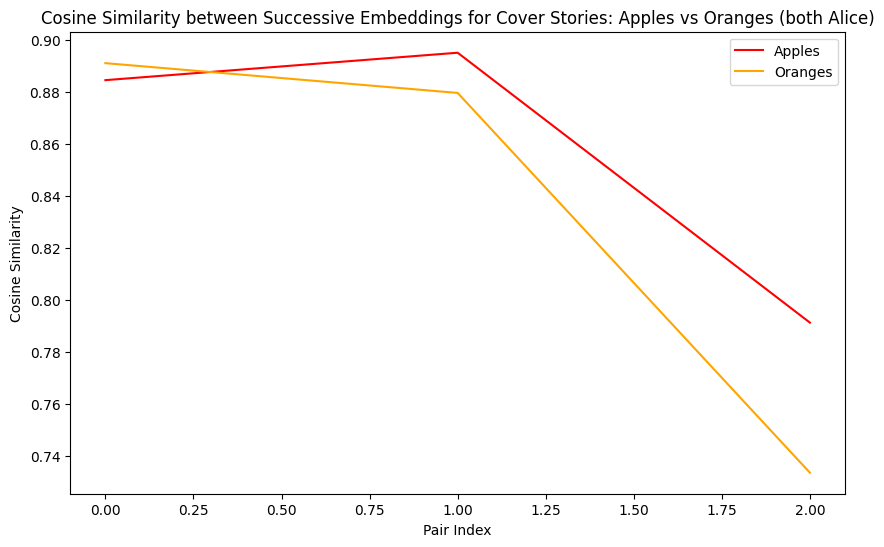

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, row in df[:2].iterrows():
    indices = list(range(len(row['cosine_similarity'])))
    if i == 0:
        plt.plot(indices, row['cosine_similarity'], color='red', label='Apples')
    elif i == 1:
        plt.plot(indices, row['cosine_similarity'], color='orange', label='Oranges')

plt.xlabel('Pair Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Successive Embeddings for Cover Stories: Apples vs Oranges (both Alice)')
plt.legend()
plt.show()


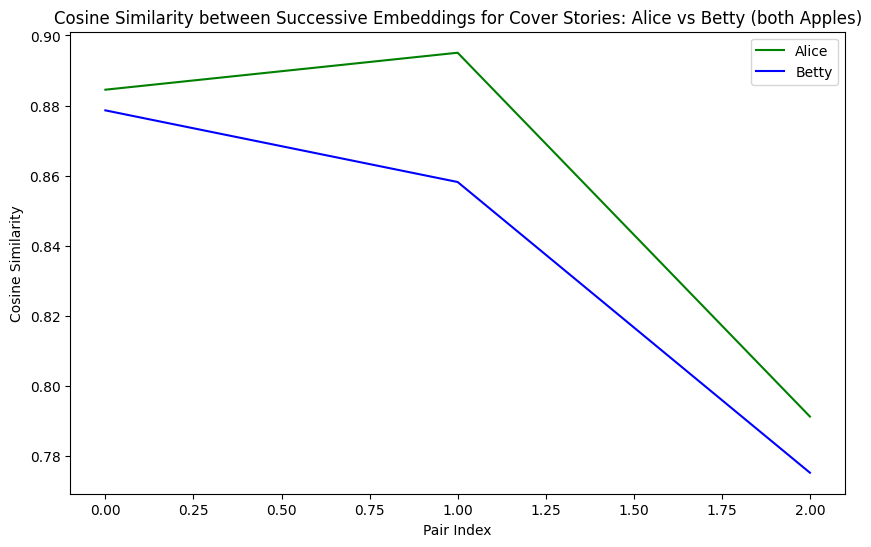

In [23]:
# Alice vs Betty
plt.figure(figsize=(10, 6))

row = df.iloc[0]
indices = list(range(len(row['cosine_similarity'])))
plt.plot(indices, row['cosine_similarity'], color='green', label='Alice')

row = df.iloc[4]
indices = list(range(len(row['cosine_similarity'])))
plt.plot(indices, row['cosine_similarity'], color='blue', label='Betty')

plt.xlabel('Pair Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Successive Embeddings for Cover Stories: Alice vs Betty (both Apples)')
plt.legend()
plt.show()

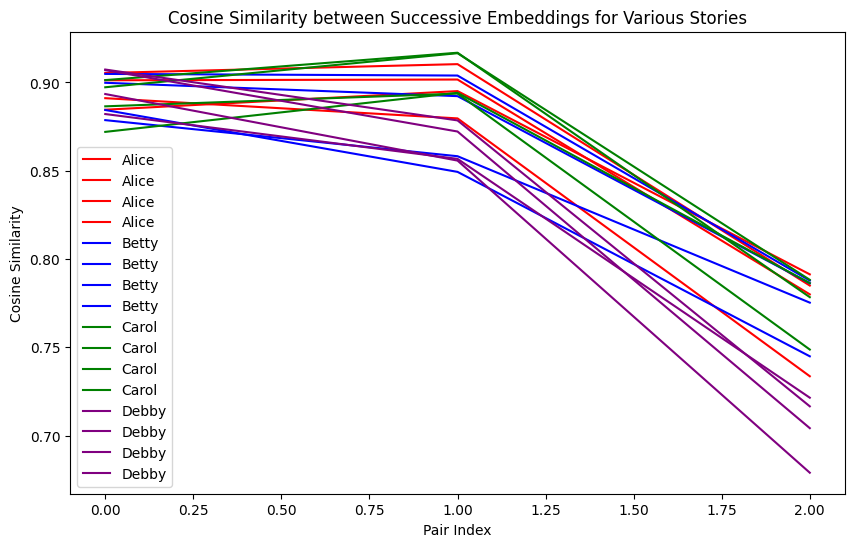

In [29]:
import matplotlib.pyplot as plt

# Define colors for each set of four rows
colors = ['red', 'blue', 'green', 'purple']
names = ['Alice', 'Betty', 'Carol', 'Debby']

plt.figure(figsize=(10, 6))

# Loop through all rows in the DataFrame
for i, row in df.iterrows():
    # Determine the color based on the row index
    color = colors[i // 4]
    name = names[i // 4]

    # Plotting
    indices = list(range(len(row['cosine_similarity'])))
    plt.plot(indices, row['cosine_similarity'], color=color, label=name if color not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Pair Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Successive Embeddings for Various Stories')
plt.legend()
plt.show()


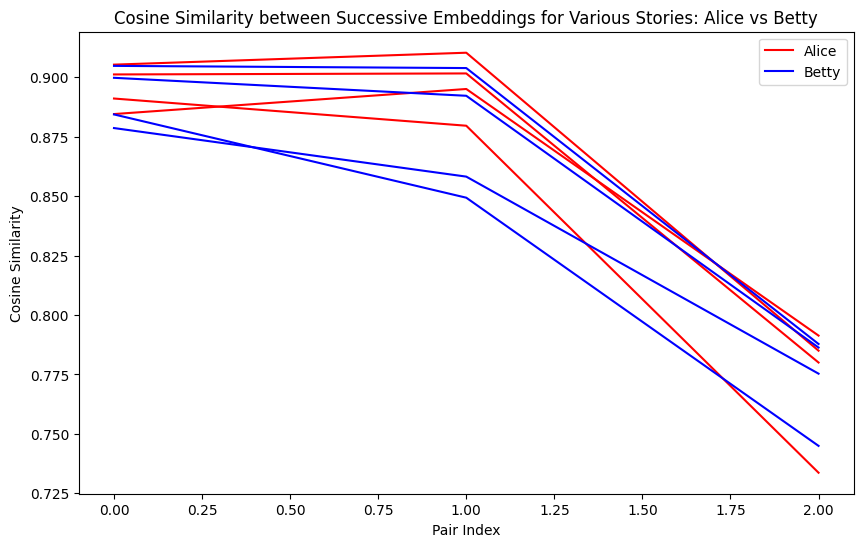

In [32]:
import matplotlib.pyplot as plt

# Define colors for each set of four rows
colors = ['red', 'blue', 'green', 'purple']
names = ['Alice', 'Betty', 'Carol', 'Debby']

# Keep track of which names have been added to the legend
added_labels = set()

plt.figure(figsize=(10, 6))

# Loop through all rows in the DataFrame
for i, row in df[:8].iterrows():
    # Determine the color and name based on the row index
    color = colors[i // 4]
    name = names[i // 4]

    # Check if the name has been added to the legend
    if name not in added_labels:
        plt.plot(indices, row['cosine_similarity'], color=color, label=name)
        added_labels.add(name)
    else:
        plt.plot(indices, row['cosine_similarity'], color=color)

plt.xlabel('Pair Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Successive Embeddings for Various Stories: Alice vs Betty')
plt.legend()
plt.show()

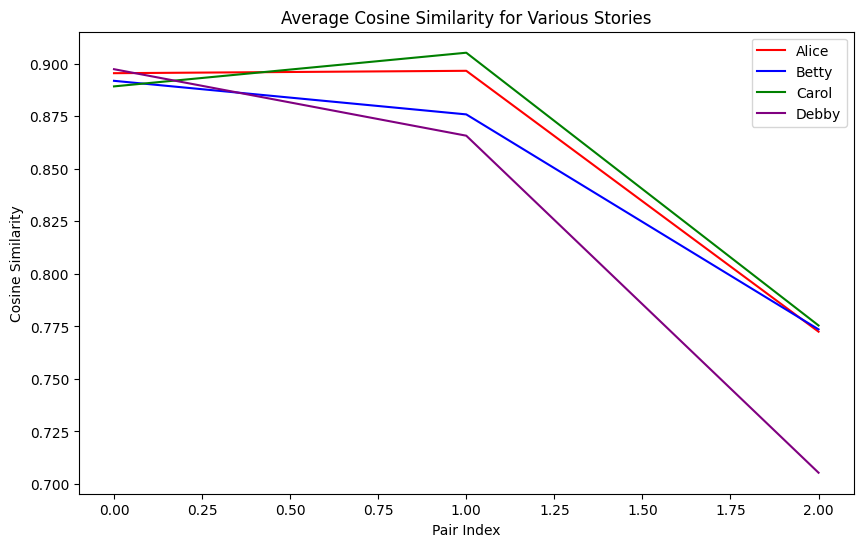

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for each name
colors = ['red', 'blue', 'green', 'purple']
names = ['Alice', 'Betty', 'Carol', 'Debby']
# colors = ['red', 'blue',]
# names = ['Alice', 'Betty',]

plt.figure(figsize=(10, 6))

# Process and plot data for each name
for i, name in enumerate(names):
    # Extract the rows for this name
    start_index = i * 4
    end_index = start_index + 4

    # Initialize lists to store cosine similarities for this group
    cosine_similarities = []

    # Iterate over the rows for the current name
    for _, row in df.iloc[start_index:end_index].iterrows():
        cosine_similarities.append(row['cosine_similarity'])

    # Calculate average, minimum, and maximum cosine similarity
    avg_cosine_similarity = np.mean(cosine_similarities, axis=0)
    min_cosine_similarity = np.min(cosine_similarities, axis=0)
    max_cosine_similarity = np.max(cosine_similarities, axis=0)

    # Indices for plotting
    indices = list(range(len(avg_cosine_similarity)))

    # Plot average line
    plt.plot(indices, avg_cosine_similarity, color=colors[i], label=name)

    # Shade between min and max values
    # plt.fill_between(indices, min_cosine_similarity, max_cosine_similarity, color=colors[i], alpha=0.2)

plt.xlabel('Pair Index')
plt.ylabel('Cosine Similarity')
plt.title('Average Cosine Similarity for Various Stories')
plt.legend()
plt.show()


In [ ]:
# 
plt.figure(figsize=(10, 6))

row = df.iloc[0]
indices = list(range(len(row['cosine_similarity'])))
plt.plot(indices, row['cosine_similarity'], color='green', label='Alice')

row = df.iloc[4]
indices = list(range(len(row['cosine_similarity'])))
plt.plot(indices, row['cosine_similarity'], color='blue', label='Betty')

plt.xlabel('Pair Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Successive Embeddings for Cover Stories: Alice vs Betty (both Apples)')
plt.legend()
plt.show()

In [103]:
def plot_cosine_similarity(df, group_by=None, plot_type='individual', color_palette=None, title="Cosine Similarity Plot"):
    """
    Plots cosine similarities from the DataFrame.

    :param df: DataFrame containing the cosine similarities and optional grouping columns.
    :param group_by: List of columns to group data by (e.g., ['name'] or ['name', 'object']).
    :param plot_type: 'individual' for plotting individual lines, 'average' for plotting average line with shaded range.
    :param color_palette: Optional list of colors to use for the groups.
    :param title: Title of the plot.
    """
    if group_by is None:
        group_by = []

    if color_palette is None:
        unique_groups = len(df[group_by[0]].unique()) if group_by else len(df)
        color_palette = plt.cm.rainbow(np.linspace(0, 1, unique_groups))

    plt.figure(figsize=(10, 6))

    for i, (group_name, group_df) in enumerate(df.groupby(group_by)):
        cosine_similarities = np.array(group_df['cosine_similarity'].tolist())
        indices = np.arange(cosine_similarities.shape[1])
        color = color_palette[i % len(color_palette)]

        if plot_type == 'individual':
            for j, row in enumerate(cosine_similarities):
                label = str(group_name) if j == 0 else None
                plt.plot(indices, row, color=color, label=label)

        elif plot_type == 'average':
            avg_cosine_similarity = np.mean(cosine_similarities, axis=0)
            min_cosine_similarity = np.min(cosine_similarities, axis=0)
            max_cosine_similarity = np.max(cosine_similarities, axis=0)
            plt.plot(indices, avg_cosine_similarity, color=color, label=str(group_name))
            plt.fill_between(indices, min_cosine_similarity, max_cosine_similarity, color=color, alpha=0.2)

    plt.xlabel('Pair Index')
    plt.ylabel('Cosine Similarity')
    plt.title(title)
    plt.legend()
    plt.show()


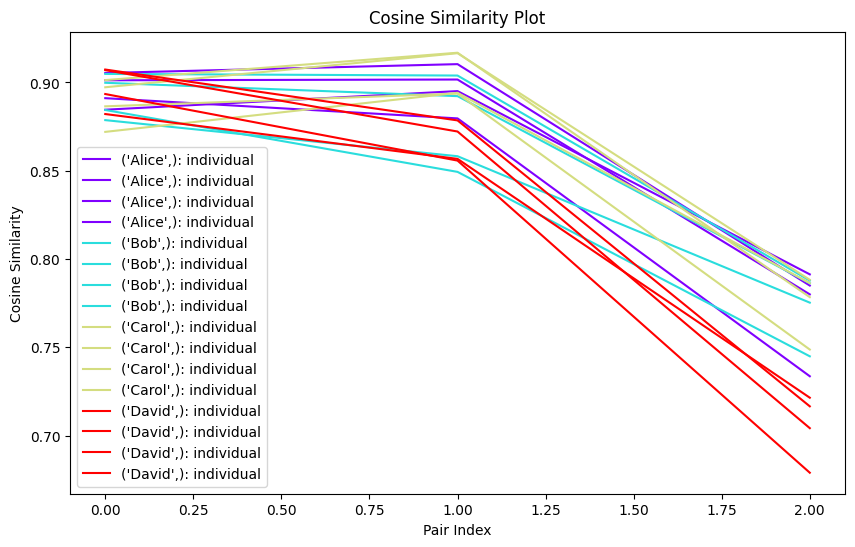

In [57]:
plot_cosine_similarity(df, group_by=['name'], plot_type='individual')

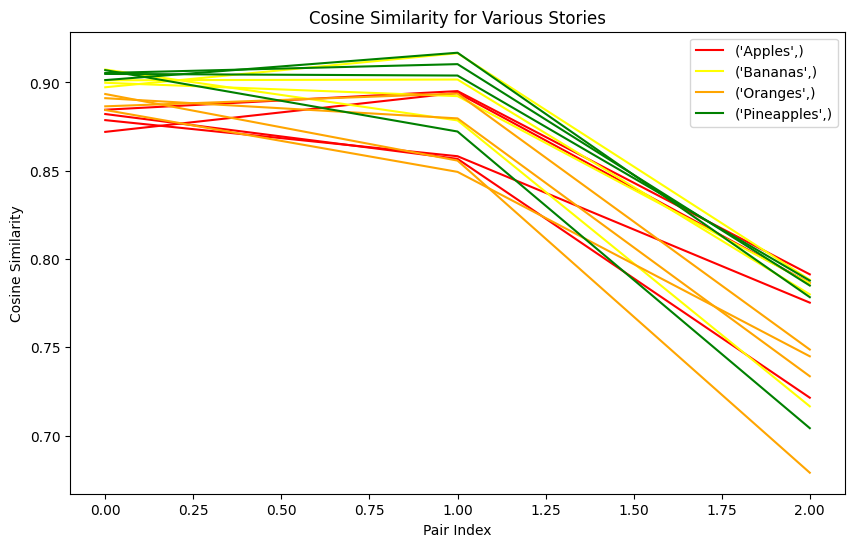

In [77]:
plot_cosine_similarity(df, group_by=['object'], plot_type='individual', color_palette=['red', 'yellow', 'orange', 'green'], title='Cosine Similarity for Various Stories')

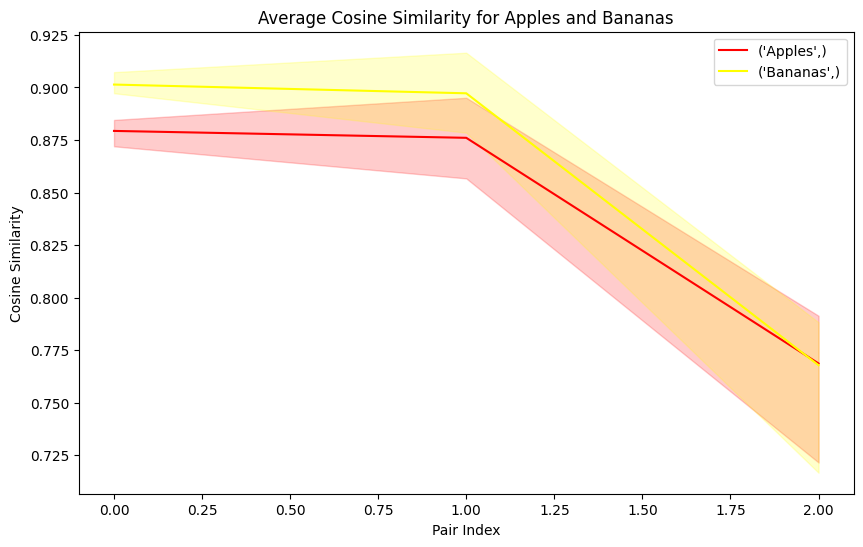

In [83]:
filtered_df = df[df['object'].isin(['Apples', 'Bananas'])]
plot_cosine_similarity(filtered_df, group_by=['object'], plot_type='average', color_palette=['red', 'yellow'], title="Average Cosine Similarity for Apples and Bananas")

In [107]:
def plot_sequence_metric(df, metric="cosine_similarity", group_by=None, plot_type='individual', color_palette=None, title=None, range=True):
    """
    Plots metrics from the DataFrame.

    :param df: DataFrame containing the metrics and optional grouping columns.
    :param group_by: List of columns to group data by (e.g., ['name'] or ['name', 'object']).
    :param plot_type: 'individual' for plotting individual lines, 'average' for plotting average line with shaded range.
    :param color_palette: Optional list of colors to use for the groups.
    :param title: Title of the plot.
    """
    if group_by is None:
        group_by = []

    if title is None:
        title = (" ".join([w.capitalize() for w in metric.split('_')]))

    if color_palette is None:
        unique_groups = len(df[group_by[0]].unique()) if group_by else len(df)
        color_palette = plt.cm.rainbow(np.linspace(0, 1, unique_groups))

    plt.figure(figsize=(10, 6))

    for i, (group_name, group_df) in enumerate(df.groupby(group_by)):
        metrics = np.array(group_df[metric].tolist())
        indices = np.arange(metrics.shape[1])
        color = color_palette[i % len(color_palette)]

        if plot_type == 'individual':
            for j, row in enumerate(metrics):
                label = str(group_name) if j == 0 else None
                plt.plot(indices, row, color=color, label=label)

        elif plot_type == 'average':
            avg_metric = np.mean(metrics, axis=0)
            min_metric = np.min(metrics, axis=0)
            max_metric = np.max(metrics, axis=0)
            plt.plot(indices, avg_metric, color=color, label=str(group_name))
            if range:
                plt.fill_between(indices, min_metric, max_metric, color=color, alpha=0.2)

    plt.xlabel('Pair Index')
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.show()

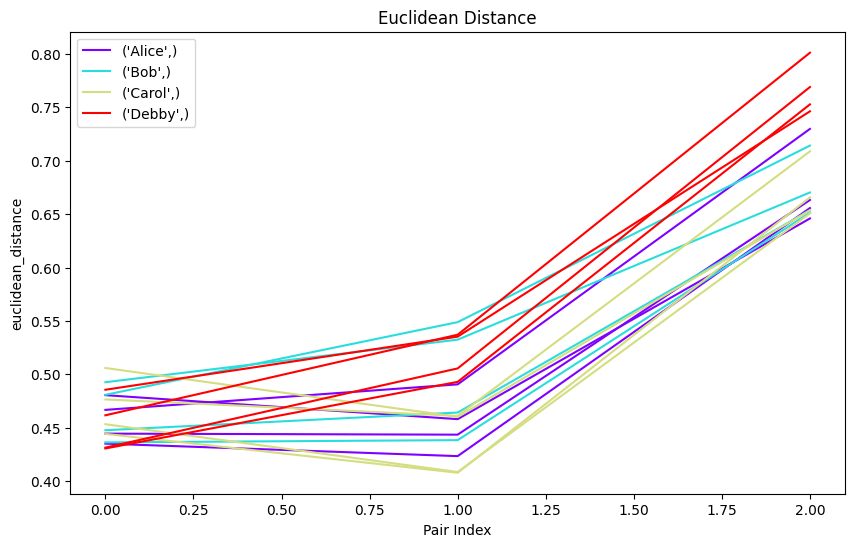

In [106]:
plot_sequence_metric(df, metric="euclidean_distance", group_by=['name'], plot_type='individual', color_palette=None)

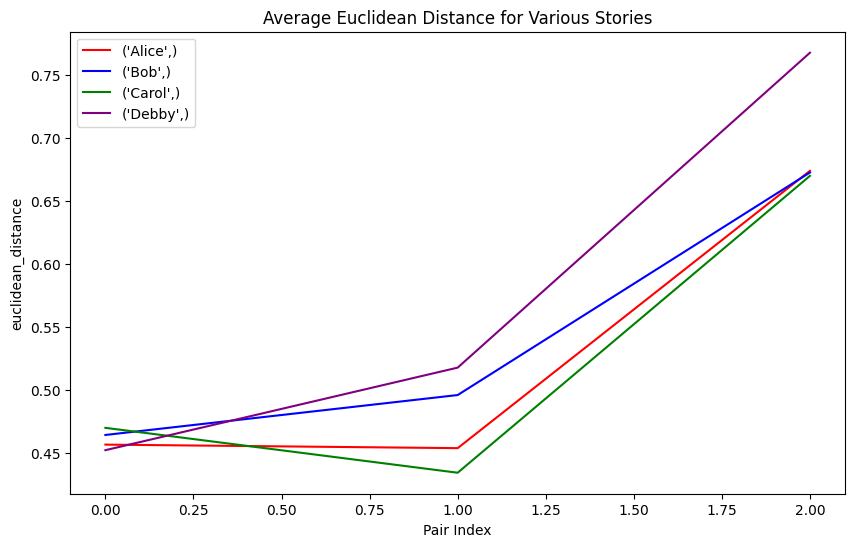

In [109]:
plot_sequence_metric(df, metric="euclidean_distance", group_by=['name'], plot_type='average', color_palette=['red', 'blue', 'green', 'purple'], title='Average Euclidean Distance for Various Stories', range=False)

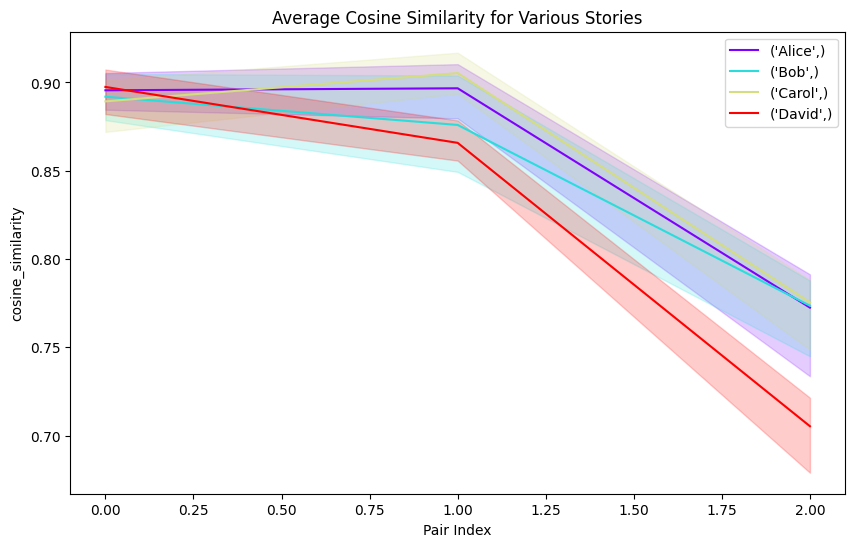

In [100]:
plot_sequence_metric(df, metric="cosine_similarity", group_by=['name'], plot_type='average', color_palette=None, title='Average Cosine Similarity for Various Stories')

In [ ]:
from scipy.spatial import distance

def plot_cot_step_metrics(cot_collection):
    """
    plots metric sequence for all inputted sentences
    """
    embeddings_collection = []
    metrics_collection = []
    for trace in cot_collection:
        embeddings = [model.encode(step) for step in trace]
        embeddings_collection.append(embeddings)
        metrics = []
        for i in range(len(embeddings) - 1):
            emb1 = embeddings[i]
            emb2 = embeddings[i + 1]

            # metric = 1 - distance.cosine(emb1, emb2)
            metric = distance.euclidean(emb1, emb2)
        metrics_collection.append(metrics)

In [124]:
from scipy.spatial import distance

def plot_cot_step_metrics(cot_collection):
    """
    Plots metric sequence for all inputted sentences
    """
    embeddings_collection = []
    metrics_collection = []
    for trace in cot_collection:
        embeddings = [model.encode(step) for step in trace]
        embeddings_collection.append(embeddings)
        metrics = []
        for i in range(len(embeddings) - 1):
            emb1 = embeddings[i]
            emb2 = embeddings[i + 1]

            metric = 1 - distance.cosine(emb1, emb2)
            # metric = distance.euclidean(emb1, emb2)
            metrics.append(metric)  # Append the metric to the metrics list

        metrics_collection.append(metrics)

    # Plotting
    plt.figure(figsize=(10, 6))
    for i, metrics in enumerate(metrics_collection):
        indices = list(range(len(metrics)))
        plt.plot(indices, metrics, label=f'Trace {i+1}')

    plt.xlabel('Step Index')
    # plt.ylabel('Euclidean Distance')
    # plt.title('Euclidean Distance between Successive Embeddings for Each Trace')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity between Successive Embeddings for Each Trace')
    plt.legend()
    plt.show()

In [111]:
cot_collection_1 = []
cot_collection_1.append(['Betty sold Apples to 48 of her friends in April, and then she sold half as many Apples in May. How many Apples did Betty sell altogether in April and May?',
 "First, let's calculate how many Apples Betty sold in May. We know that she sold half as many Apples in May as she did in April. So, we can find this by dividing the number of Apples she sold in April by 2. 48 Apples / 2 = 24 Apples Therefore, Betty sold 24 Apples in May.",
 "Now, let's calculate how many Apples she sold altogether in April and May. We can find this by adding the number of Apples she sold in April and the number of Apples she sold in May. 48 Apples + 24 Apples = 72 Apples",
 'Therefore, Betty sold a total of 72 Apples in April and May.'])
cot_collection_1.append(['Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 "First, let's calculate how many clips Natalia sold in May. We know that she sold half as many clips in May as she did in April. So, we can find this by dividing the number of clips she sold in April by 2.  48 clips / 2 = 24 clips  Therefore, Natalia sold 24 clips in May.",
 "Now, let's calculate how many clips she sold altogether in April and May. We can find this by adding the number of clips she sold in April and the number of clips she sold in May.  48 clips + 24 clips = 72 clips",
 'Therefore, Natalia sold a total of 72 clips in April and May.'])

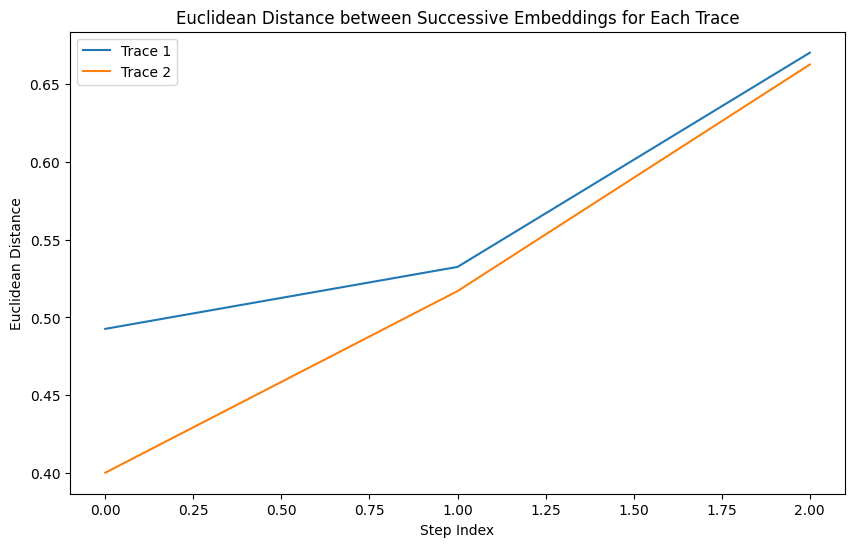

In [114]:
plot_cot_step_metrics(cot_collection_1)

In [119]:
cot_collection_2 = []
cot_collection_2.append(['Betty sold Apples to 48 of her friends in April, and then she sold half as many Apples in May. How many Apples did Betty sell altogether in April and May?',
 "First, let's calculate how many Apples Betty sold in May. We know that she sold half as many Apples in May as she did in April. So, we can find this by dividing the number of Apples she sold in April by 2. 48 Apples / 2 = 24 Apples Therefore, Betty sold 24 Apples in May.",
 "Now, let's calculate how many Apples she sold altogether in April and May. We can find this by adding the number of Apples she sold in April and the number of Apples she sold in May. 48 Apples + 24 Apples = 72 Apples",
 'Therefore, Betty sold a total of 72 Apples in April and May.'])
cot_collection_2.append(['Step 1: Ken added enough jelly beans to bring the weight to 2 pounds. So after adding the jelly beans, the weight of the box is 2 pounds.',
 'Step 2: Ken added enough brownies to cause the weight to triple. Since the weight tripled, the weight of the box is now 2 * 3 = 6 pounds.',
 'Step 3: Ken added another 2 pounds of jelly beans. After adding the additional jelly beans, the weight of the box is 6 + 2 = 8 pounds.',
 'Step 4: Ken added enough gummy worms to double the weight once again. Since the weight doubled, the final weight of the box is 8 * 2 = 16 pounds.',
 'Therefore, the final weight of the box of goodies is 16 pounds.'])
cot_collection_2.append(["First, let's add up the costs of the items Alexis did buy.   $30 (shirt) + $46 (pants) + $38 (coat) + $11 (socks) + $18 (belt) = $143",
 "Next, let's subtract the total cost of the items Alexis bought from her budget to see how much she has left.  $200 (budget) - $143 (total cost of items bought) = $57",
 'Since Alexis has $16 left, we can subtract that from the remaining amount to find the cost of the shoes.  $57 (remaining budget) - $16 (remaining amount) = $41',
 'Therefore, Alexis paid $41 for the shoes.'])

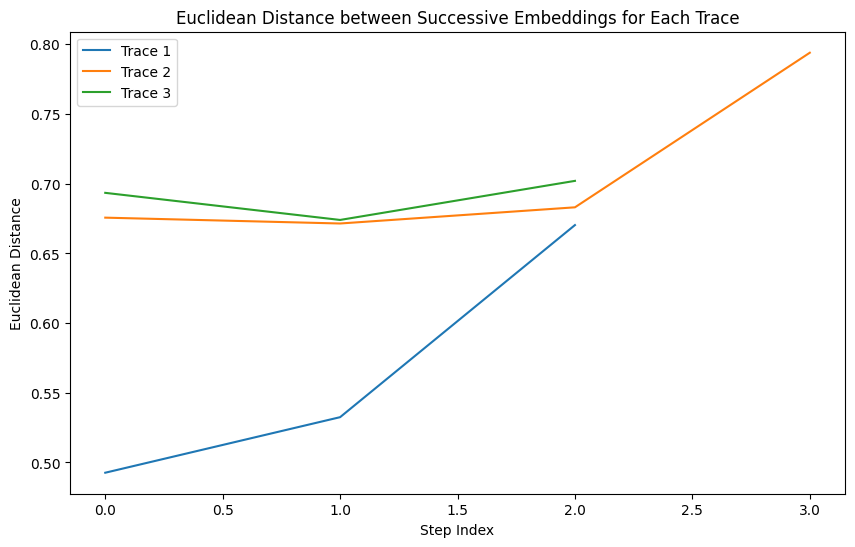

In [123]:
plot_cot_step_metrics(cot_collection_2)

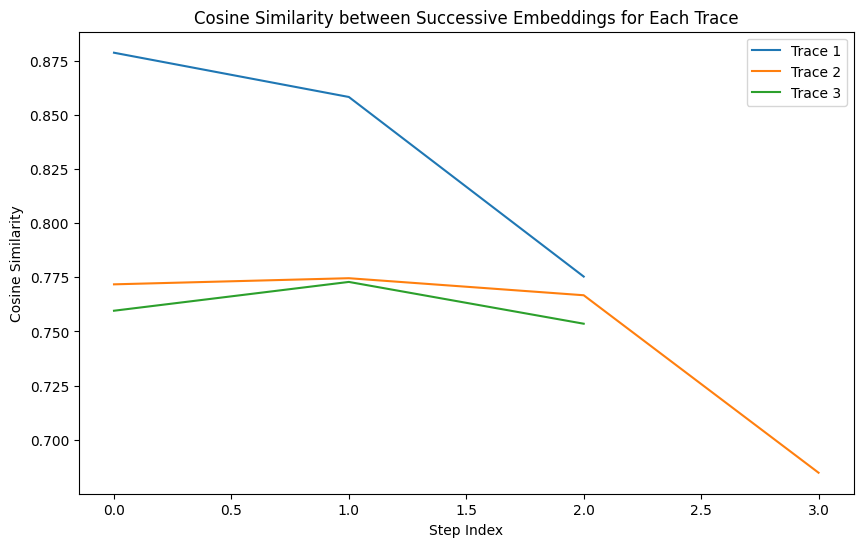

In [125]:
plot_cot_step_metrics(cot_collection_2)